Module importing

In [1]:
import sys
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import scipy.signal as signal
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

sys.path.append('/workspace/my_tool/model')
from multiResUnet_1D import MultiResUnet
sys.path.append('/workspace/my_tool/tool')
from model_builder import k_fold_training
from performance import performance
sys.path.append('/workspace/my_tool/tool/data_load')
from ppg_labeled_load import PPGDataset

Data prepairing

(1024,)
torch.Size([1, 4, 1024])


/workspace/my_tool/tool/data_load/ppg_labeled_load.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  label = torch.tensor([self.lab[index]],dtype=torch.float32)


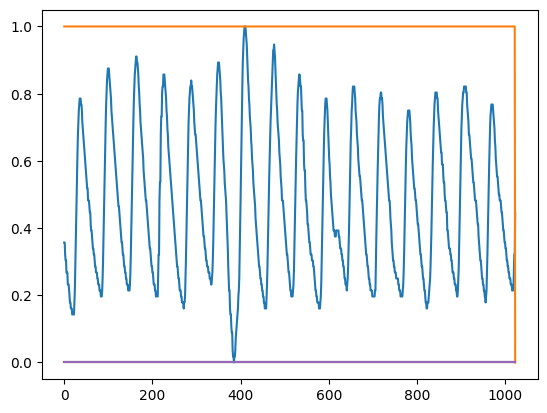

438
2190


In [2]:
def preprocess(data):
    if np.sum(data["Syn_Label"])>1:
        signal = data["Syn_PPG"]
        label = [1 if x > 0 else x for x in data["Syn_Label"]]
    return signal,label

#AF = 1, PAC,PVC = 2
def preprocess_case_1(data):
    s = data["Syn_PPG"]
    l = [2 if x in [3,4,5,6,7,8,9,10,11] else x for x in data["Syn_Label"]]
    return s,l

#AF = 1, PAC,PVC = 2, PAC,PVC-couple = 3
def preprocess_case_2(data):
    s = data["Syn_PPG"]
    # l = [2 if x in [3,4] else x for x in data["Syn_Label"]]
    # l = [3 if x in [5,6,7,8,9,10,11] else x for x in data["Syn_Label"]]
    # l1 = [1 if x == 1 else (0 if x not in (0, 1) else x) for x in data["Syn_Label"]]
    # l2 = [1 if x in (3,4) else (0 if x not in (0, 1) else x) for x in data["Syn_Label"]]
    # l3 = [1 if x in (5,6,7,8,9,10,11) else (0 if x not in (0, 1) else x) for x in data["Syn_Label"]]
    L = len(data["Syn_Label"])
    label = np.zeros((4,L))
    for i in range(L-1):
        if data["Syn_Label"][i] == 0:
            label[0][i] = 1
        elif data["Syn_Label"][i] == 1:
            label[1][i] = 1
        elif data["Syn_Label"][i] in (3,4):
            label[2][i] = 1
        else:
            label[3][i] = 1

    return s,label

#Import_data
dataset = PPGDataset('/workspace/data/packaged_data',preprocessing=preprocess_case_2)
index = random.randint(0, len(dataset)-1)
z = dataset[0][0].numpy().flatten()
print(z.shape)
print(dataset[0][1].shape)
plt.plot(dataset[0][0].numpy().flatten())
plt.plot(dataset[0][1][0][0].numpy().flatten())
plt.plot(dataset[0][1][0][1].numpy().flatten())
plt.plot(dataset[0][1][0][2].numpy().flatten())
plt.plot(dataset[0][1][0][3].numpy().flatten())
# plt.plot(dataset[0][1].numpy())
plt.show()

N = len(dataset)
test_len = int(N*0.2)
train_len = N-test_len

train_data, test_data = random_split(dataset, [train_len, test_len])
print(len(test_data))
print(len(dataset))

Training

In [3]:
import torch.nn.functional as F

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

para = {"Number class":             4,
			"Serie length":         1024, #The length of the 1D data
            "Filter nums":          [32,64,128], #The number of filters for each multiresblocks of one side of the model (1xn) 
            "Expand":               [2,2,2], #The number of stride (1x[n-1])
			"Respath kernel":       3, #The kernel size of each respath (1x1)
            "Block kernel":         [3,5,7], #The kernel size of each multiresblocks (1x3)
			"Filter rate":          [1.67,0.333,0.5], #The ratio of filer number of each multiresblock (1x3)
			"Pooling kernel":       [2,2,2], #The kernel size of each pooling layer (1xn)
			"Transpose kernel":     [2,2,2]	#
    }

def loss(predict, truth):
    truth = truth.to(torch.int64)  # Ensure labels are int64 for PyTorch compatibility
    log_prob = F.log_softmax(predict, dim=1)  # Compute log-softmax
    loss = -log_prob.gather(dim=1, index=truth.unsqueeze(1)).squeeze(1)  # Gather log probabilities of the correct classes
    return loss.mean()

model = MultiResUnet(para = para, alpha = 1.67)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
builder = k_fold_training(train_data, 1, criterion = nn.MSELoss())
builder.training(model,device,optimizer,num_epochs=1000,batch=64,visualize=1)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 4, 1024])) that is different to the input size (torch.Size([64, 4, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([24, 1, 4, 1024])) that is different to the input size (torch.Size([24, 4, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration: 1/1000. loss_train: 0.1752667118396078. loss_val: 0
Iteration: 2/1000. loss_train: 0.15814197223101342. loss_val: 0
Iteration: 3/1000. loss_train: 0.15581483872873442. loss_val: 0
Iteration: 4/1000. loss_train: 0.1548306063881942. loss_val: 0
Iteration: 5/1000. loss_train: 0.15399450808763504. loss_val: 0
Iteration: 6/1000. loss_train: 0.15338814152138575. loss_val: 0
Iteration: 7/1000. loss_train: 0.15268085524439812. loss_val: 0
Iteration: 8/1000. loss_train: 0.15205360842602594. loss_val: 0
Iteration: 9/1000. loss_train: 0.1516049424452441. loss_val: 0
Iteration: 10/1000. loss_train: 0.15085769657577788. loss_val: 0
Iteration: 11/1000. loss_train: 0.15045152444924628. loss_val: 0
Iteration: 12/1000. loss_train: 0.14995834550687245. loss_val: 0
Iteration: 13/1000. loss_train: 0.14964994362422399. loss_val: 0
Iteration: 14/1000. loss_train: 0.1489910281130246. loss_val: 0
Iteration: 15/1000. loss_train: 0.1486124891255583. loss_val: 0
Iteration: 16/1000. loss_train: 0.14832

Performance

Max loss:  0.48350924
Mean loss:  0.15820841
Min loss:  0.0926312
Number of test:  438


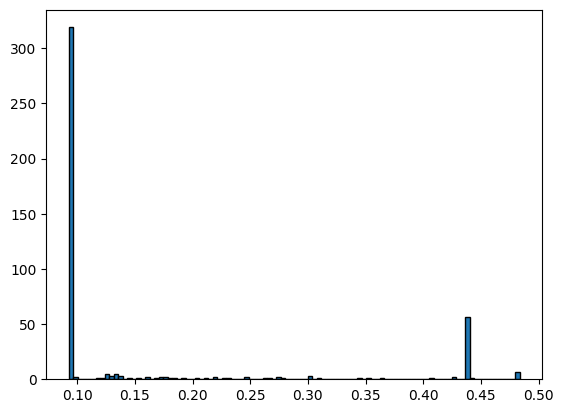

torch.Size([1, 1, 4, 1024])
0.35779548


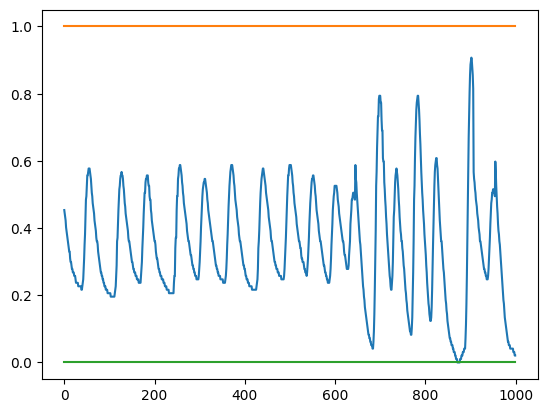

torch.Size([1, 1, 4, 1024])
0.35802904


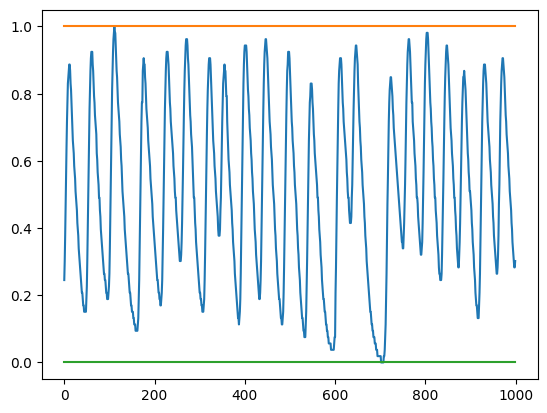

torch.Size([1, 1, 4, 1024])
0.012949225


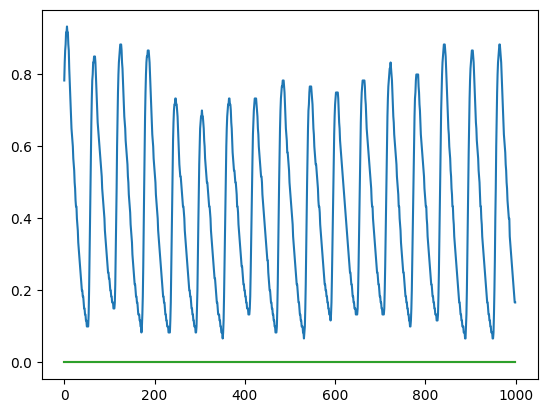

torch.Size([1, 1, 4, 1024])
0.35764995


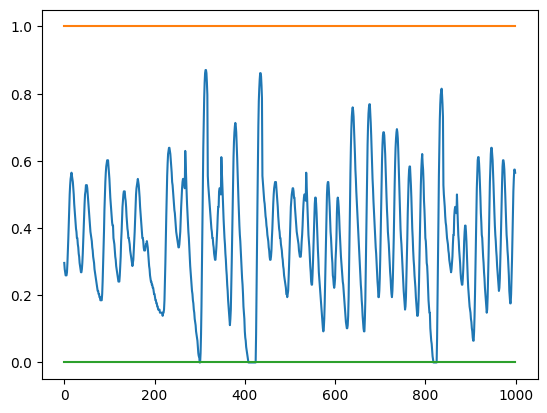

torch.Size([1, 1, 4, 1024])
0.012987269


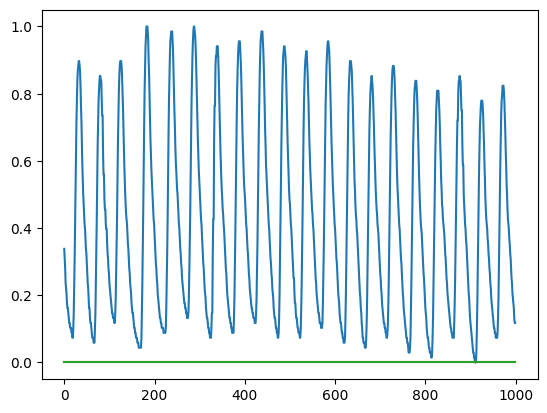

torch.Size([1, 1, 4, 1024])
0.013006508


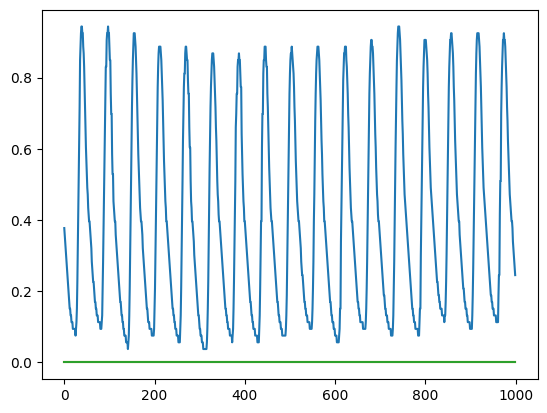

torch.Size([1, 1, 4, 1024])
0.052478842


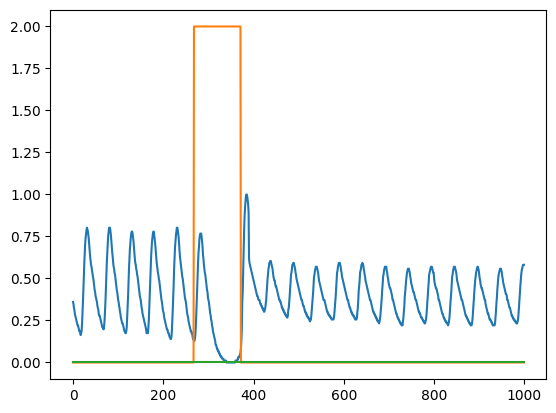

torch.Size([1, 1, 4, 1024])
0.012989551


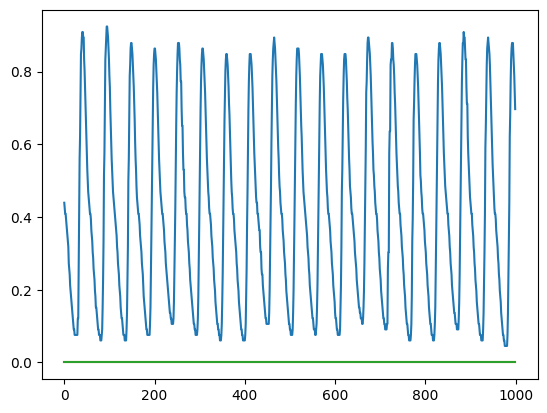

torch.Size([1, 1, 4, 1024])
0.012964658


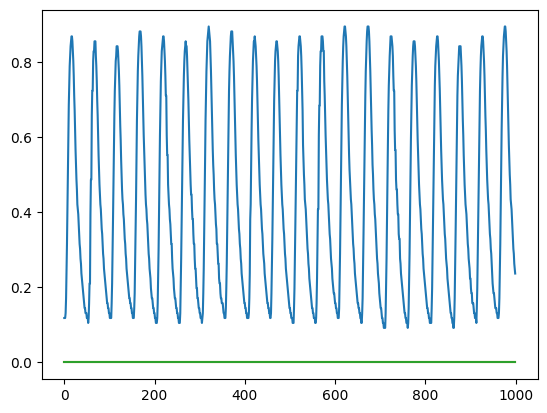

torch.Size([1, 1, 4, 1024])
0.26459396


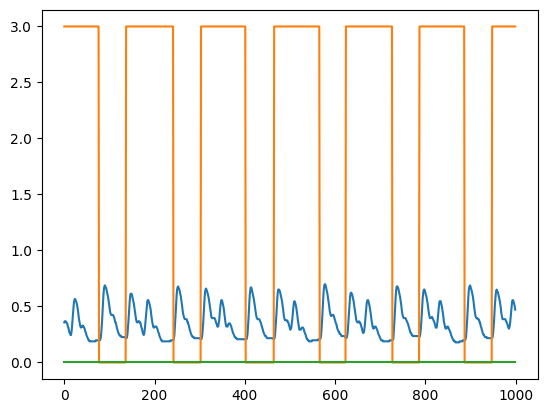

torch.Size([1, 1, 4, 1024])
0.35788733


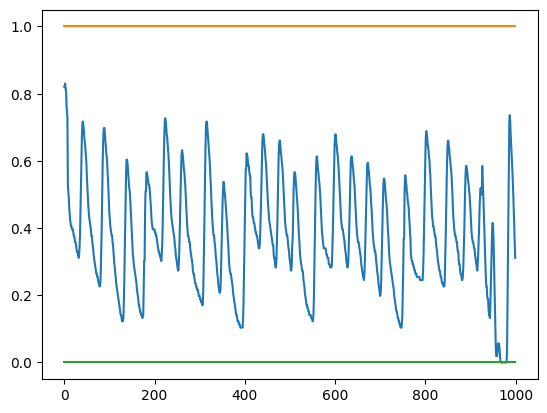

torch.Size([1, 1, 4, 1024])
0.013010642


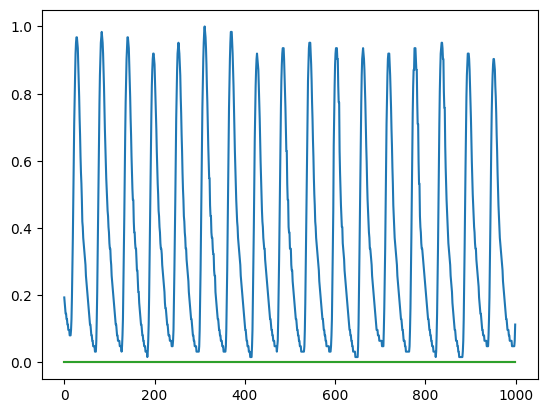

torch.Size([1, 1, 4, 1024])
0.013000698


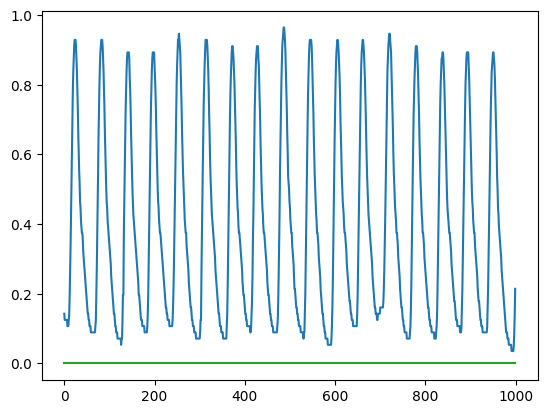

torch.Size([1, 1, 4, 1024])
0.013012319


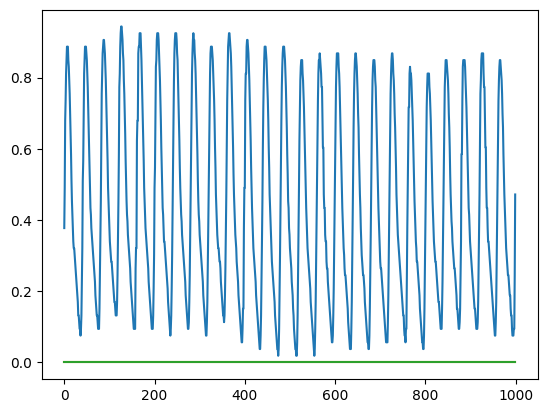

torch.Size([1, 1, 4, 1024])
0.01298963


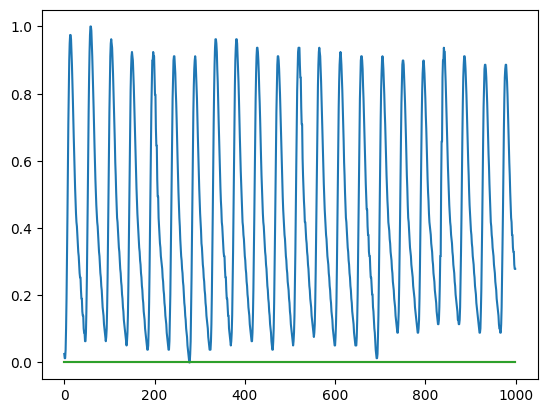

torch.Size([1, 1, 4, 1024])
0.16508442


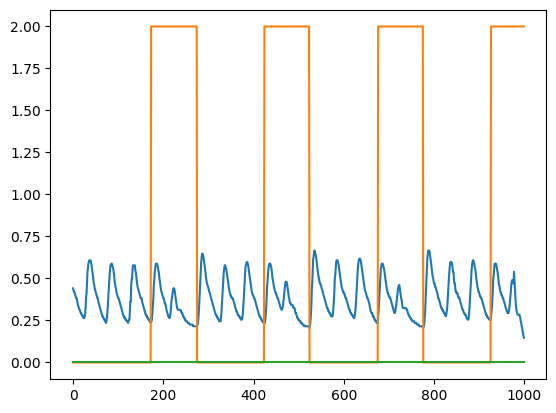

torch.Size([1, 1, 4, 1024])
0.012949539


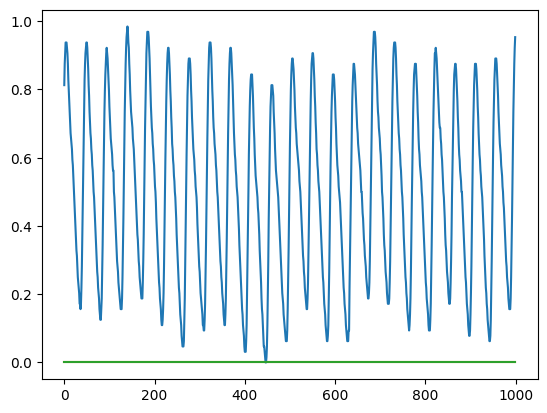

torch.Size([1, 1, 4, 1024])
0.012961423


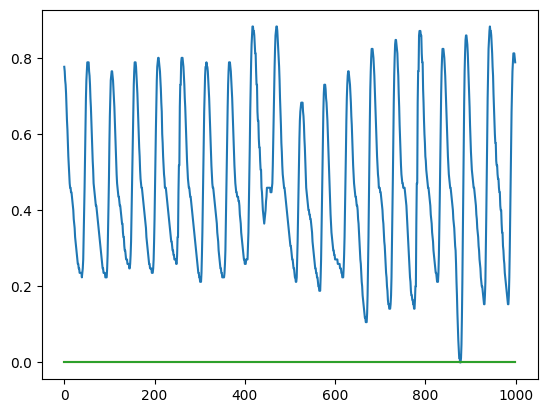

torch.Size([1, 1, 4, 1024])
0.012941038


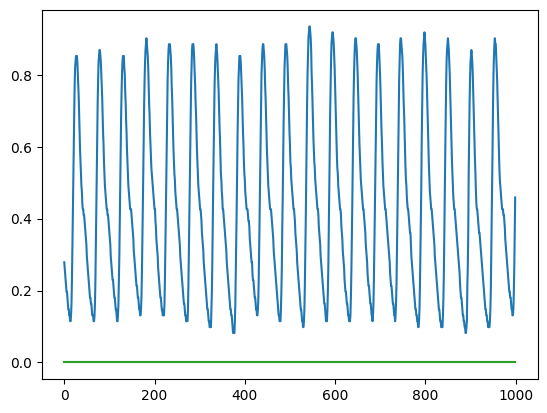

torch.Size([1, 1, 4, 1024])
0.013005766


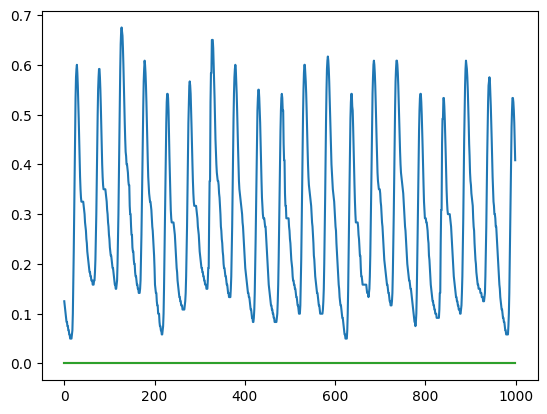

torch.Size([1, 1, 4, 1024])
0.047203474


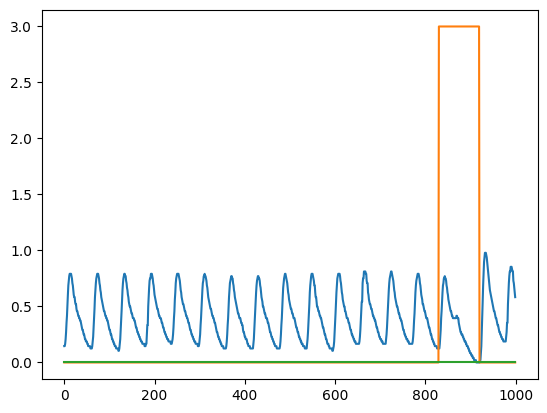

torch.Size([1, 1, 4, 1024])
0.013003811


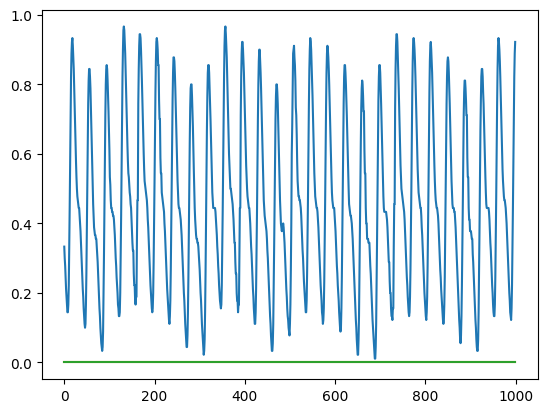

torch.Size([1, 1, 4, 1024])
0.012999726


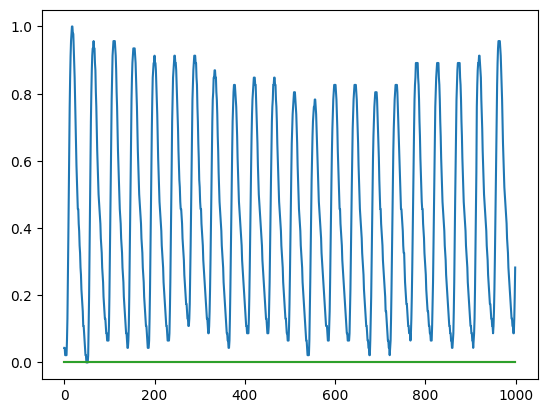

torch.Size([1, 1, 4, 1024])
0.013009482


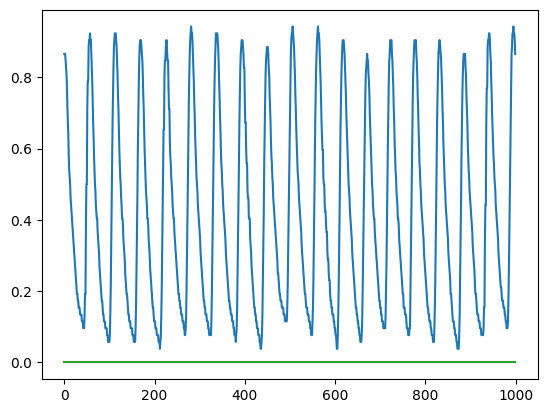

torch.Size([1, 1, 4, 1024])
0.3577992


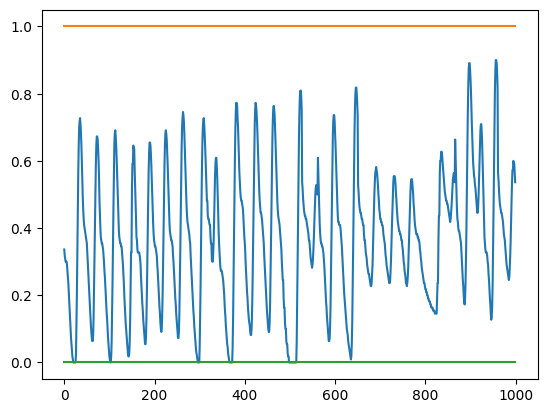

torch.Size([1, 1, 4, 1024])
0.40341723


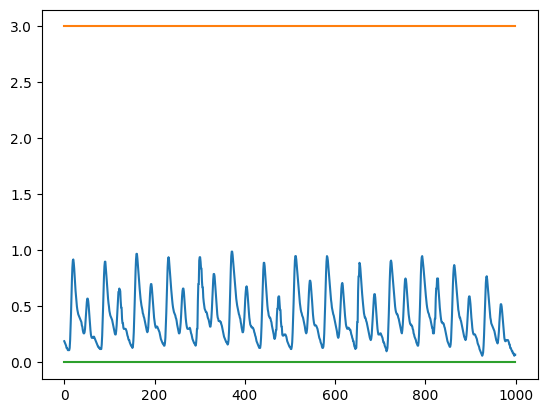

torch.Size([1, 1, 4, 1024])
0.012938151


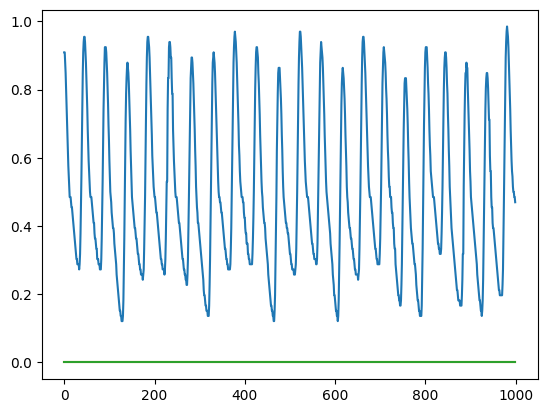

torch.Size([1, 1, 4, 1024])
0.013211457


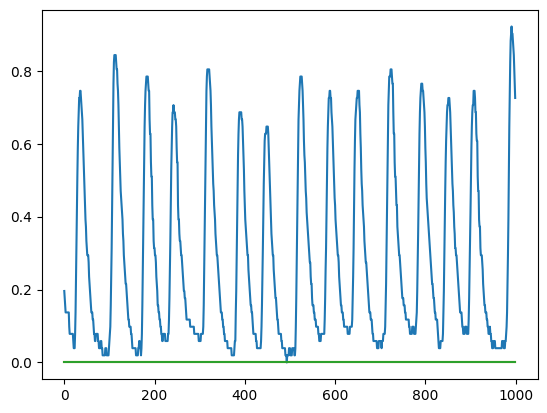

torch.Size([1, 1, 4, 1024])
0.013016174


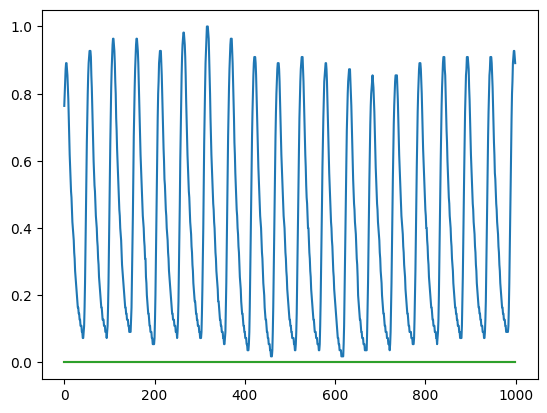

torch.Size([1, 1, 4, 1024])
0.012997291


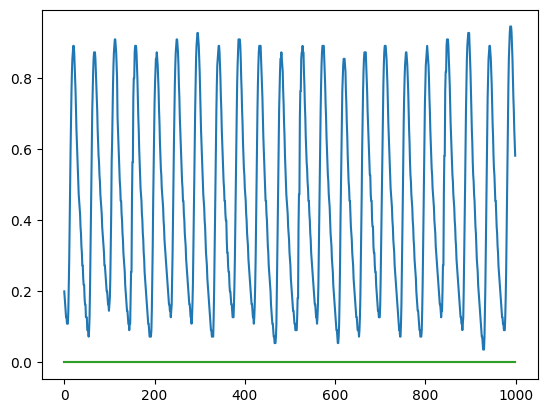

torch.Size([1, 1, 4, 1024])
0.012959912


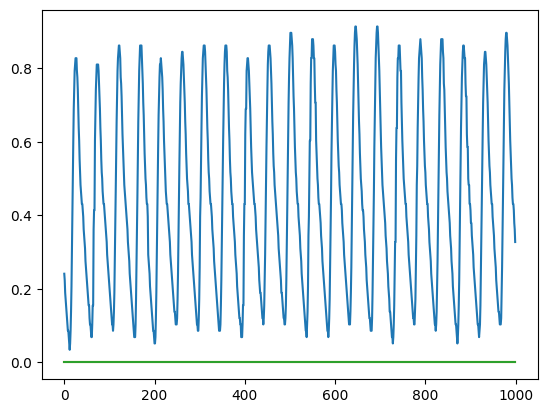

torch.Size([1, 1, 4, 1024])
0.012939818


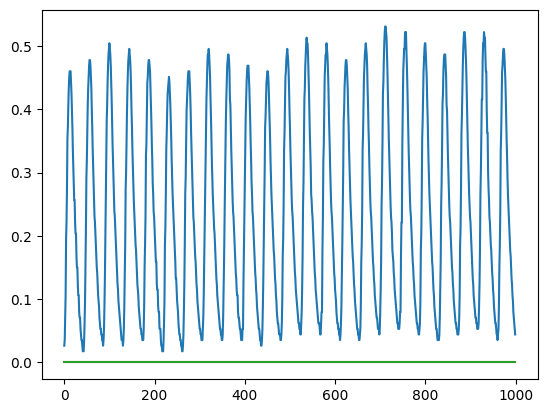

torch.Size([1, 1, 4, 1024])
0.013000846


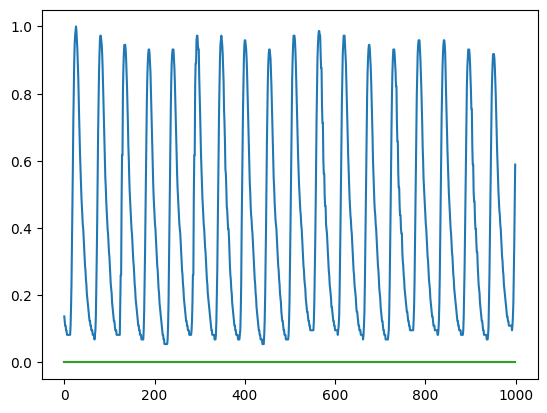

torch.Size([1, 1, 4, 1024])
0.012968626


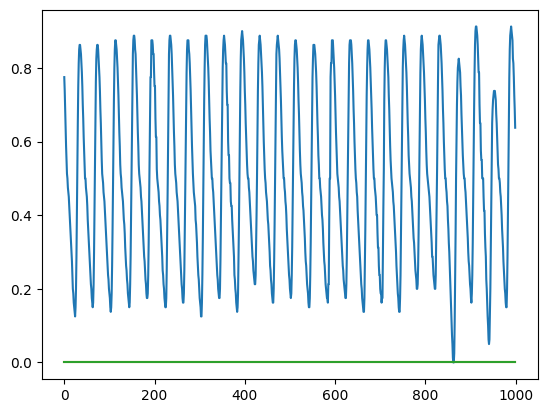

torch.Size([1, 1, 4, 1024])
0.012980022


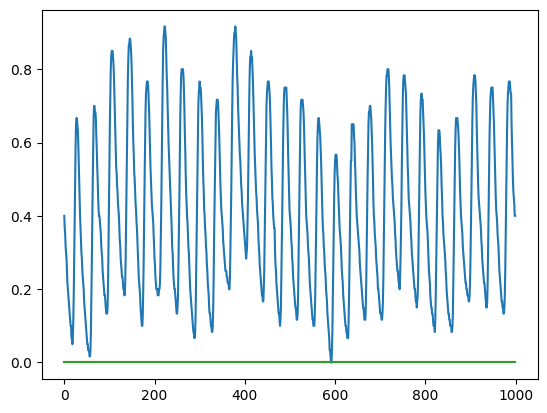

torch.Size([1, 1, 4, 1024])
0.012957286


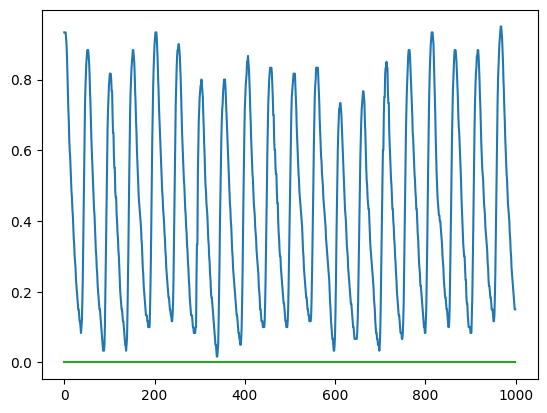

torch.Size([1, 1, 4, 1024])
0.012931168


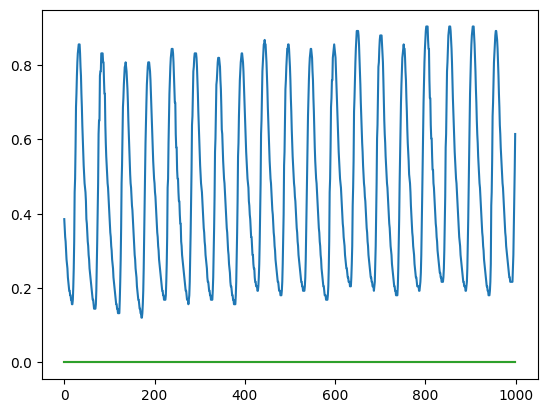

torch.Size([1, 1, 4, 1024])
0.012978002


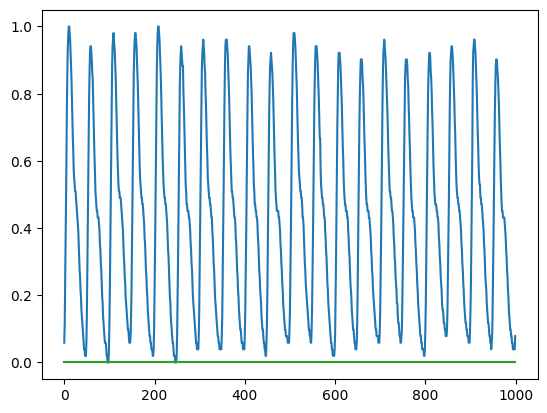

torch.Size([1, 1, 4, 1024])
0.012978567


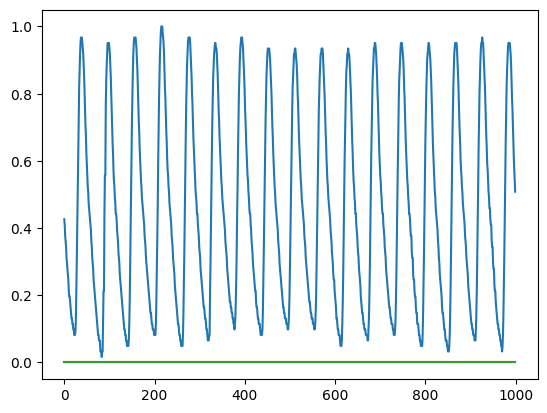

torch.Size([1, 1, 4, 1024])
0.0129892025


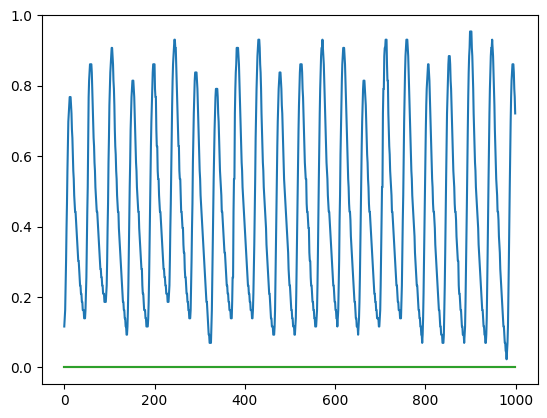

torch.Size([1, 1, 4, 1024])
0.012959081


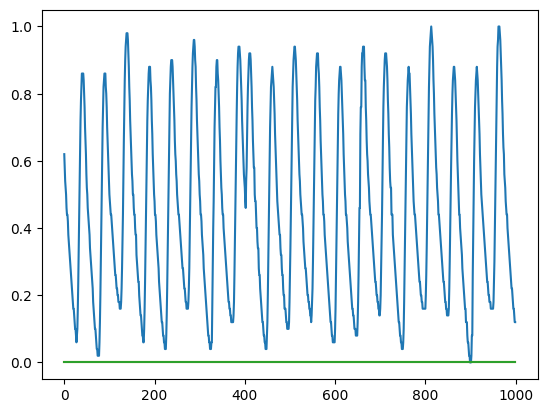

torch.Size([1, 1, 4, 1024])
0.012989485


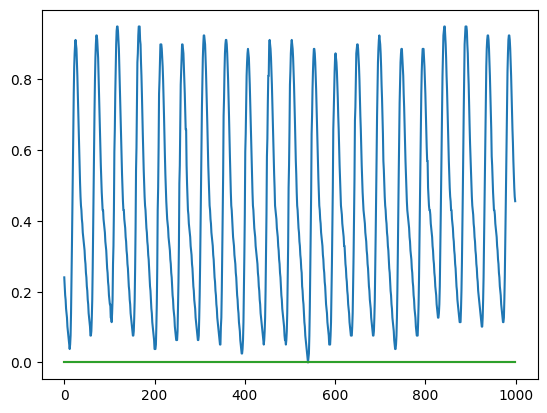

torch.Size([1, 1, 4, 1024])
0.0129493745


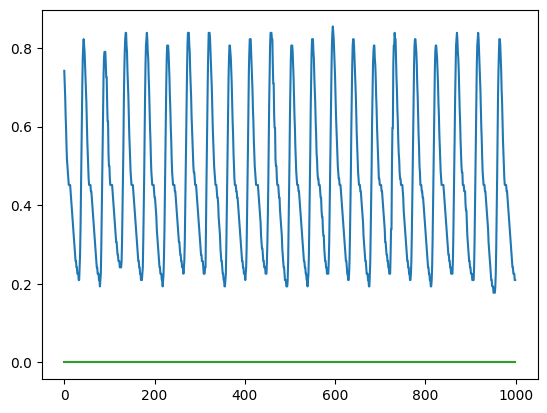

torch.Size([1, 1, 4, 1024])
0.35743773


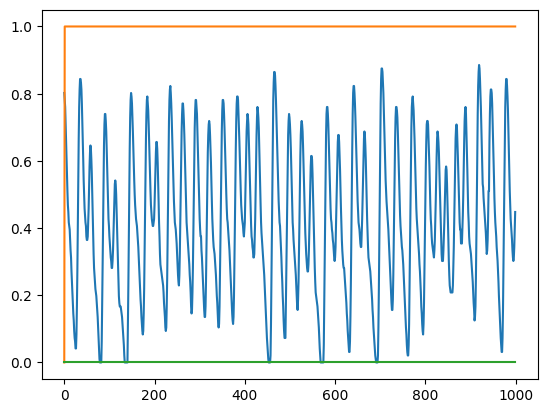

torch.Size([1, 1, 4, 1024])
0.013176469


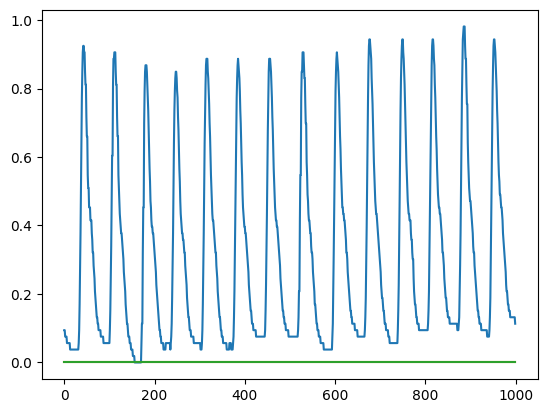

torch.Size([1, 1, 4, 1024])
0.013028663


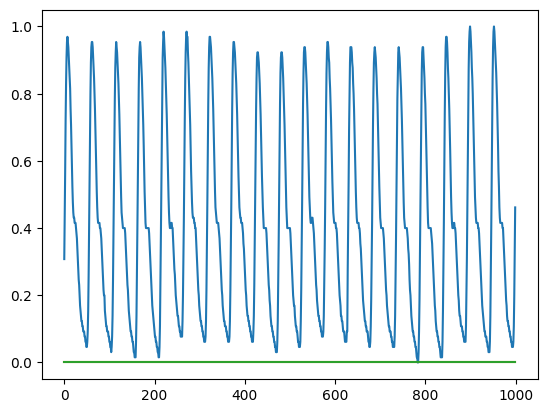

torch.Size([1, 1, 4, 1024])
0.01298468


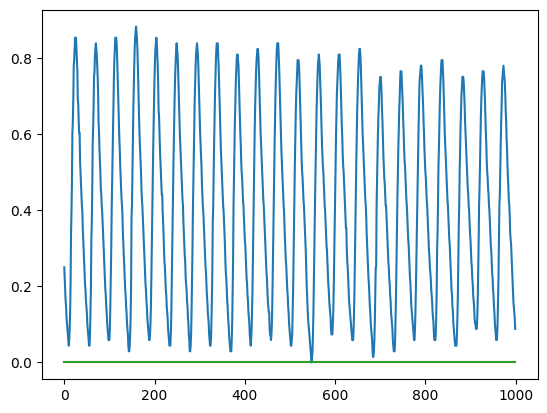

torch.Size([1, 1, 4, 1024])
0.01300518


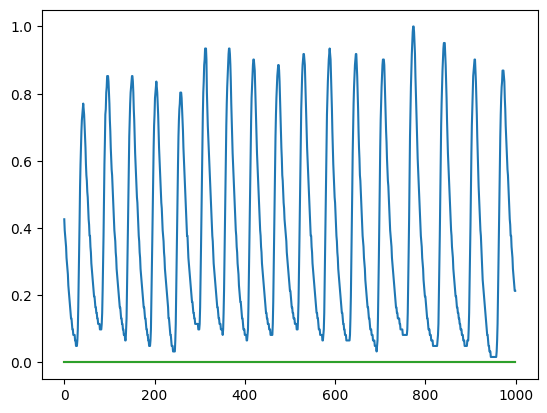

torch.Size([1, 1, 4, 1024])
0.05469875


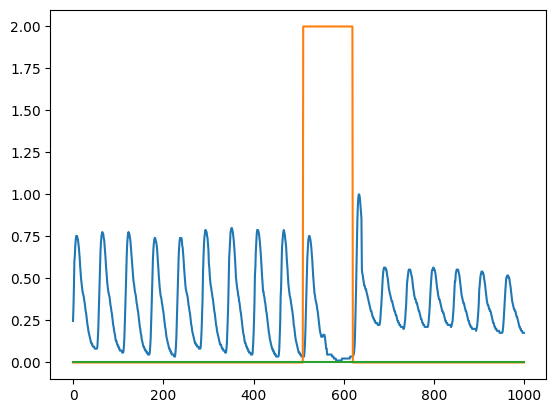

torch.Size([1, 1, 4, 1024])
0.013036024


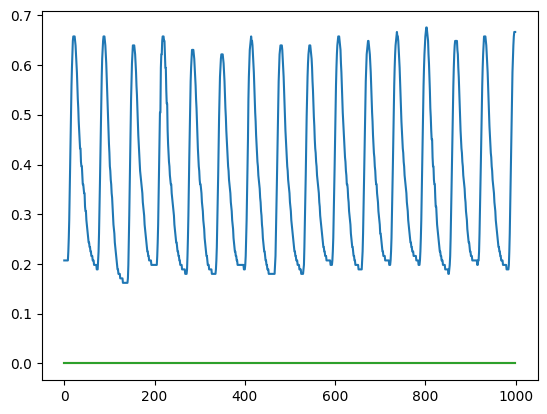

torch.Size([1, 1, 4, 1024])
0.012942761


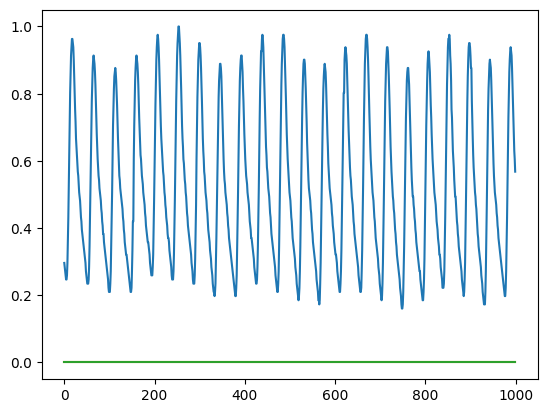

torch.Size([1, 1, 4, 1024])
0.013018442


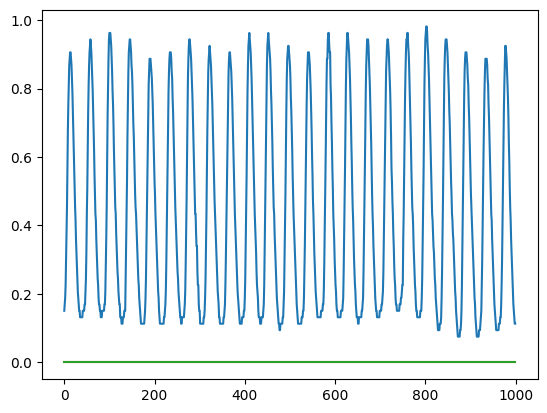

torch.Size([1, 1, 4, 1024])
0.012969977


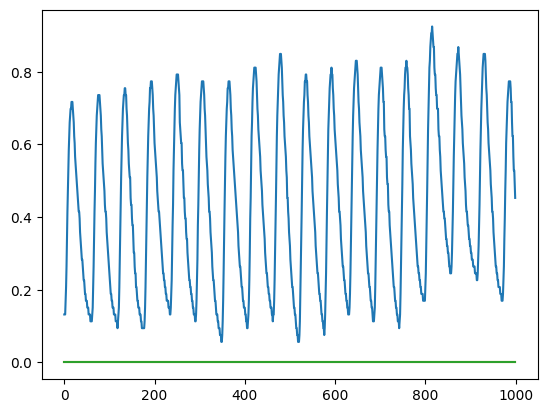

torch.Size([1, 1, 4, 1024])
0.013027422


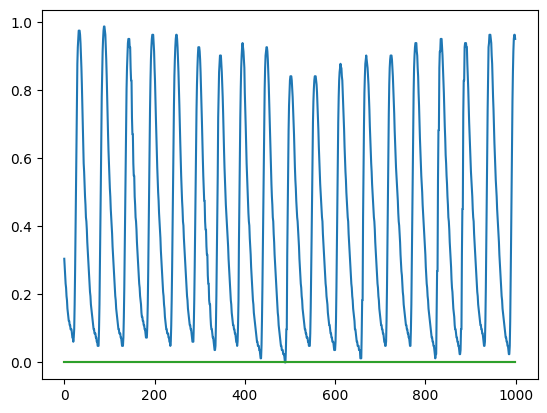

torch.Size([1, 1, 4, 1024])
0.35786772


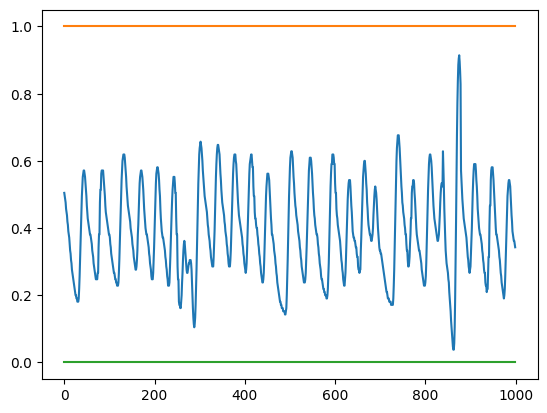

torch.Size([1, 1, 4, 1024])
0.013003092


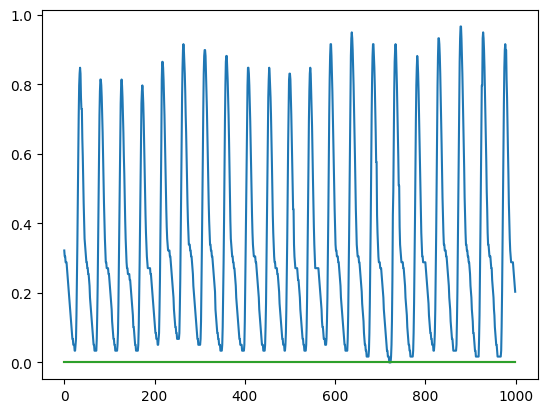

torch.Size([1, 1, 4, 1024])
0.012974178


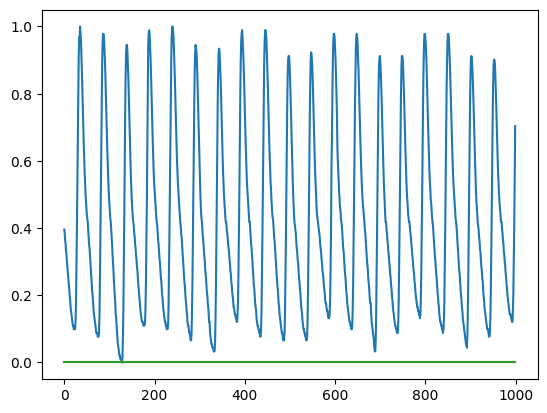

torch.Size([1, 1, 4, 1024])
0.012949097


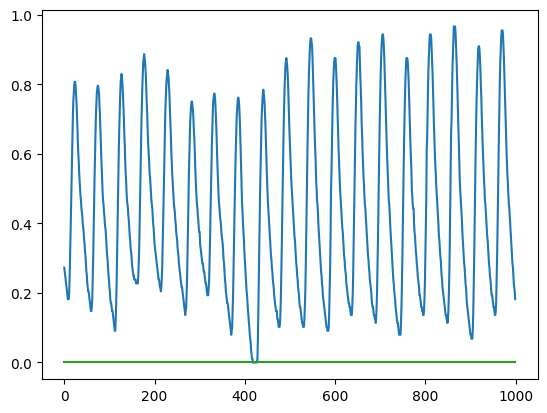

torch.Size([1, 1, 4, 1024])
0.013011321


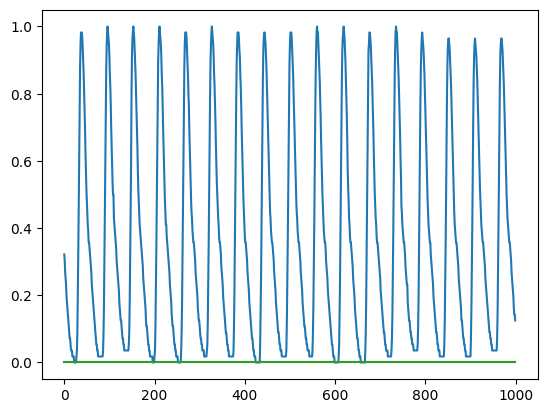

torch.Size([1, 1, 4, 1024])
0.35763812


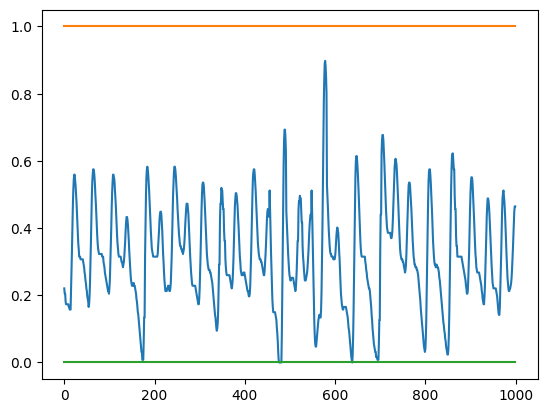

torch.Size([1, 1, 4, 1024])
0.012961462


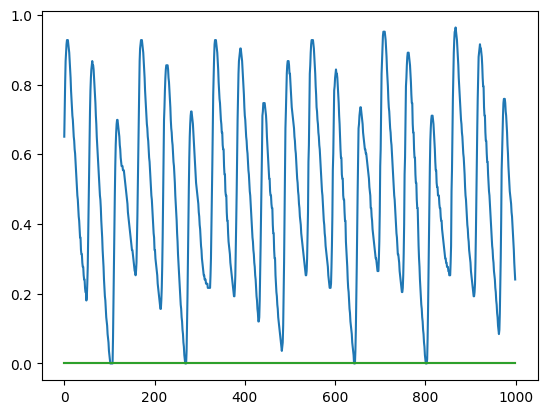

torch.Size([1, 1, 4, 1024])
0.012980901


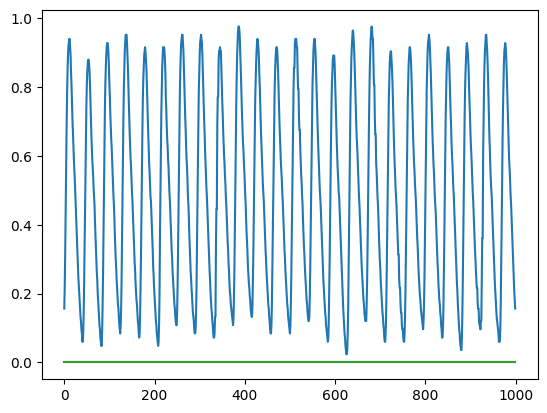

torch.Size([1, 1, 4, 1024])
0.013025161


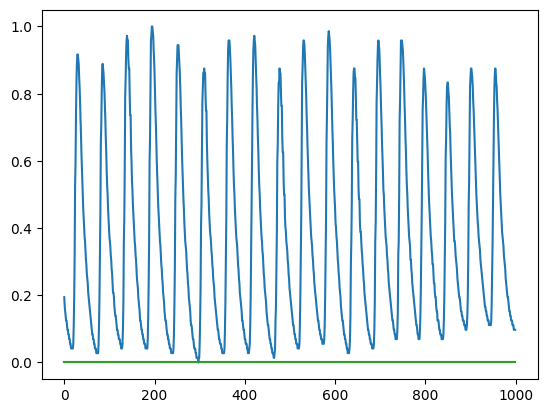

torch.Size([1, 1, 4, 1024])
0.012940461


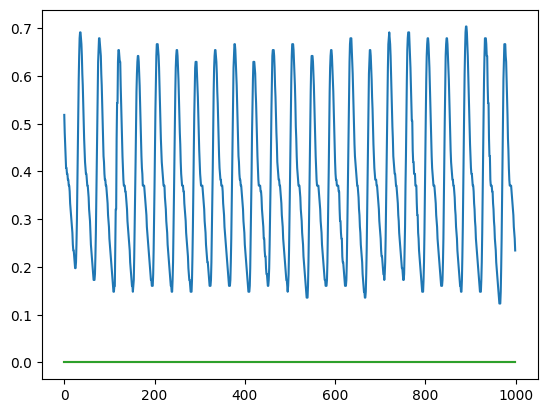

torch.Size([1, 1, 4, 1024])
0.35800308


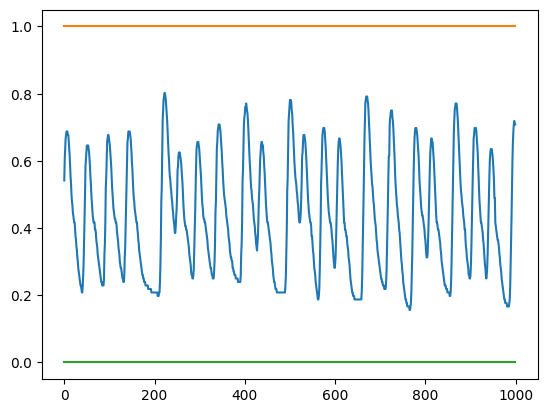

torch.Size([1, 1, 4, 1024])
0.01307562


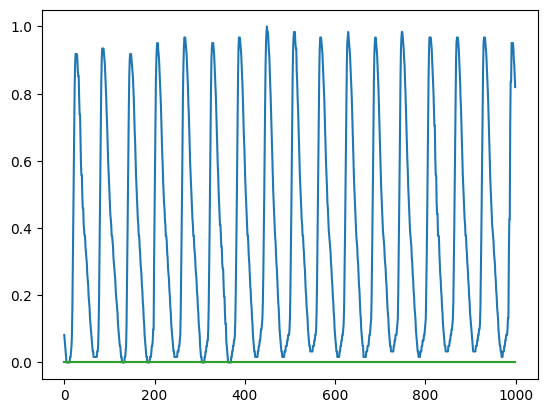

torch.Size([1, 1, 4, 1024])
0.013028577


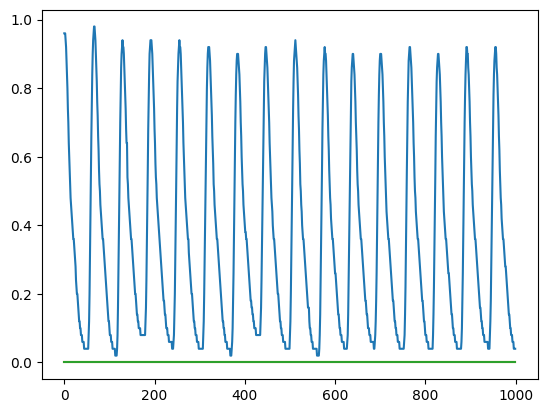

torch.Size([1, 1, 4, 1024])
0.013014397


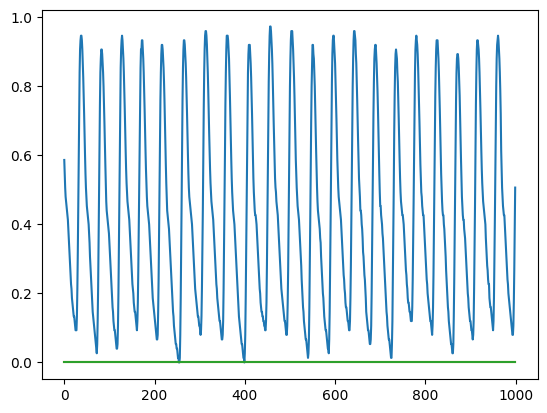

torch.Size([1, 1, 4, 1024])
0.012975187


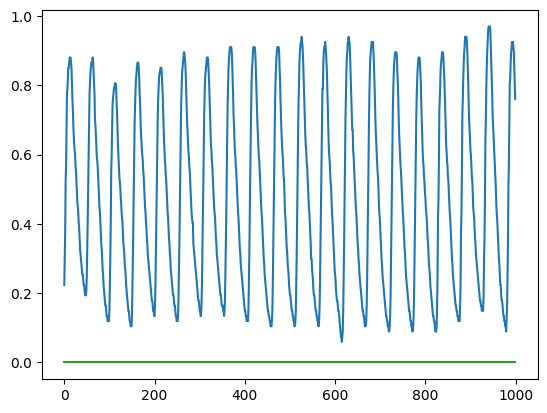

torch.Size([1, 1, 4, 1024])
0.036232654


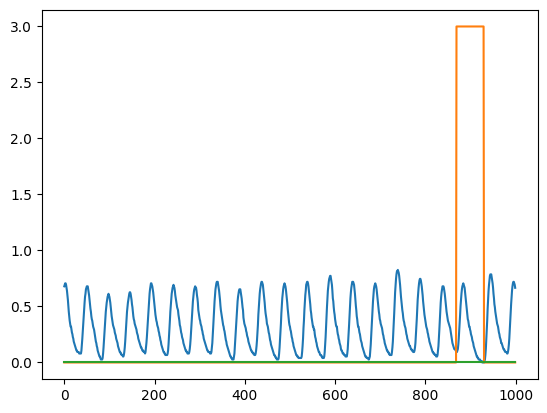

torch.Size([1, 1, 4, 1024])
0.013005948


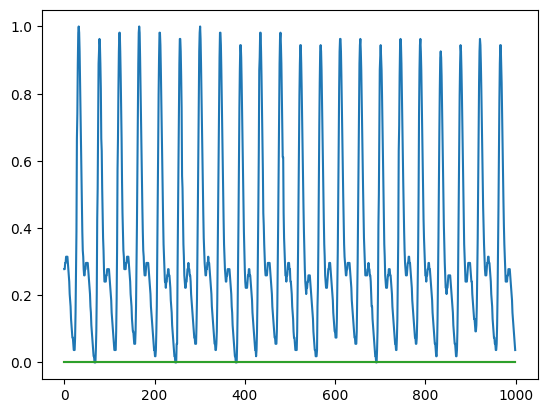

torch.Size([1, 1, 4, 1024])
0.012909602


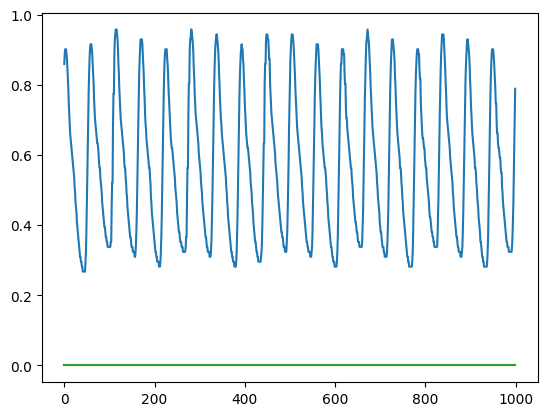

torch.Size([1, 1, 4, 1024])
0.013046505


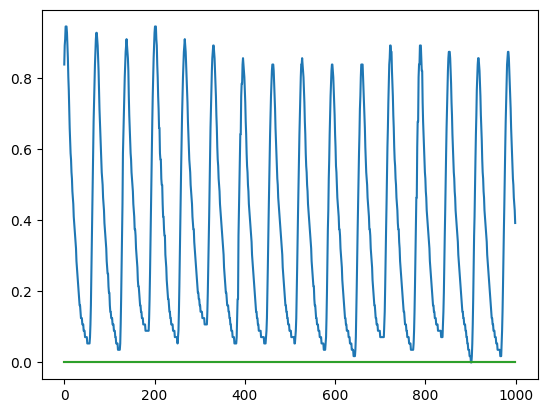

torch.Size([1, 1, 4, 1024])
0.013022497


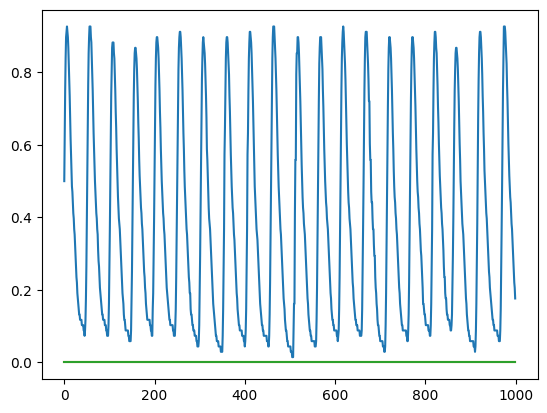

torch.Size([1, 1, 4, 1024])
0.012994865


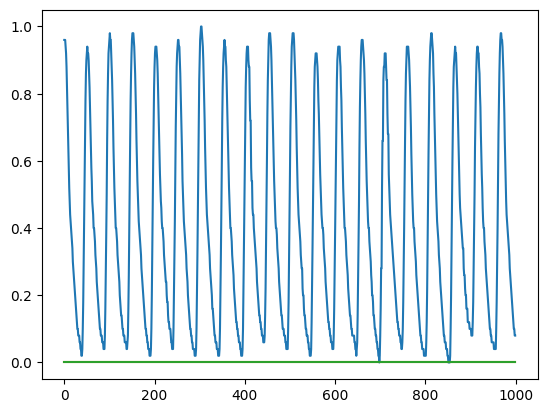

torch.Size([1, 1, 4, 1024])
0.012976028


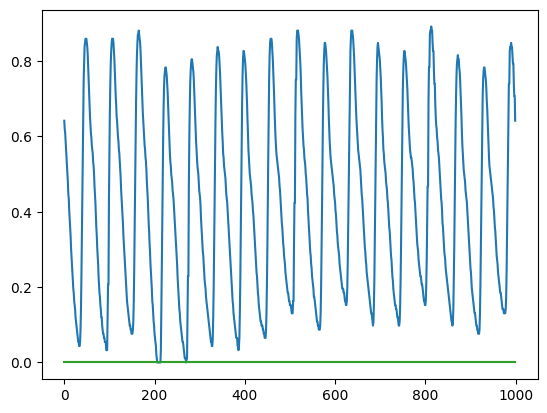

torch.Size([1, 1, 4, 1024])
0.013017362


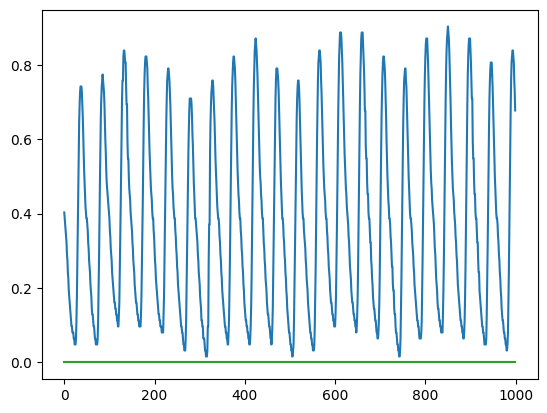

torch.Size([1, 1, 4, 1024])
0.35759395


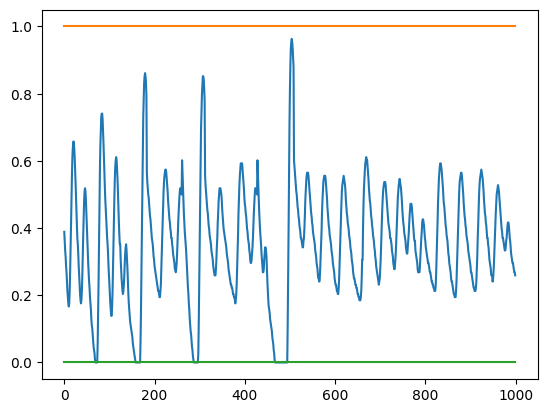

torch.Size([1, 1, 4, 1024])
0.35757092


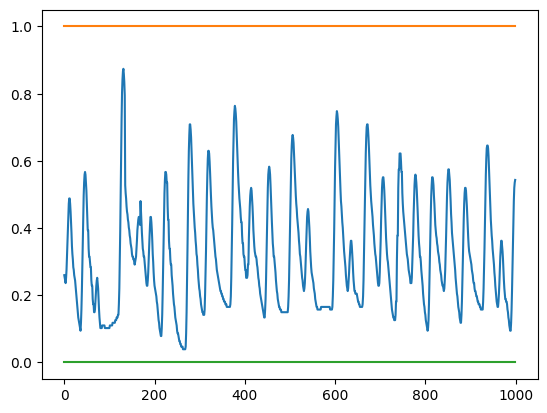

torch.Size([1, 1, 4, 1024])
0.013011465


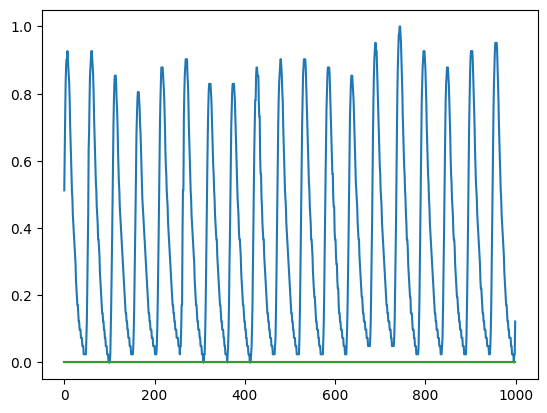

torch.Size([1, 1, 4, 1024])
0.012991034


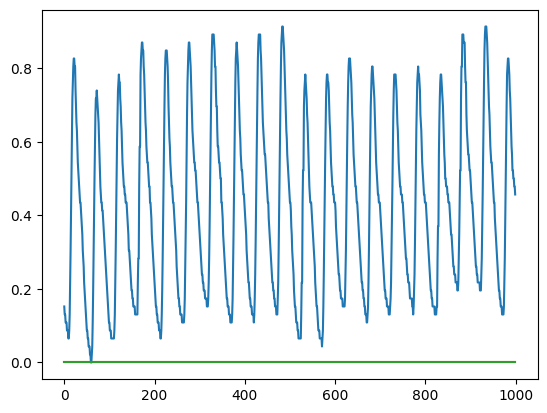

torch.Size([1, 1, 4, 1024])
0.013006061


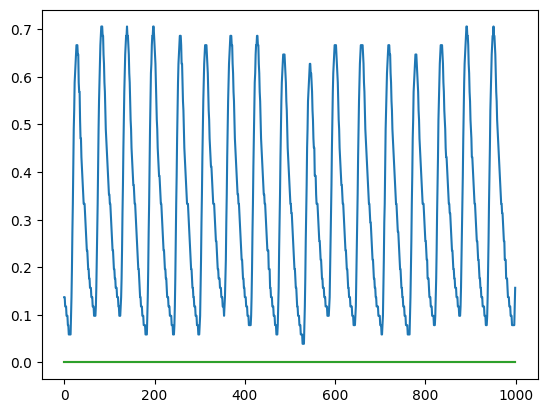

torch.Size([1, 1, 4, 1024])
0.013003293


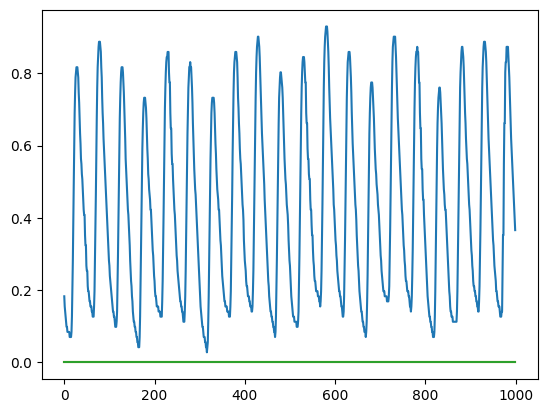

torch.Size([1, 1, 4, 1024])
0.013000321


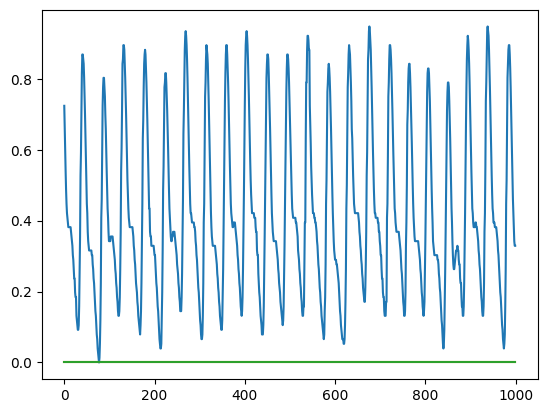

torch.Size([1, 1, 4, 1024])
0.039884754


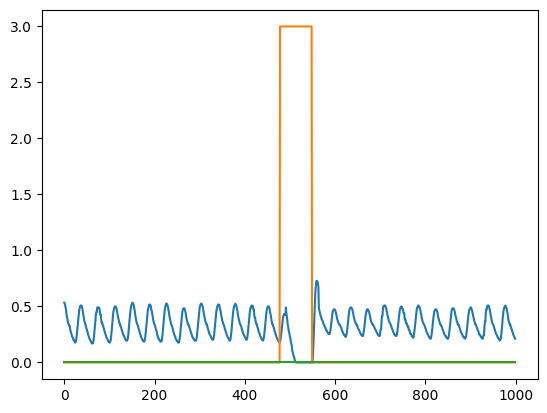

torch.Size([1, 1, 4, 1024])
0.012913416


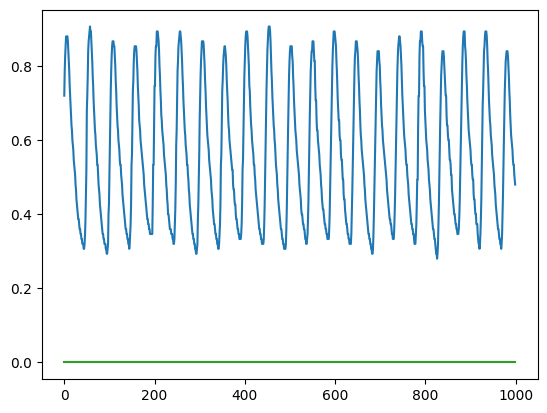

torch.Size([1, 1, 4, 1024])
0.013090193


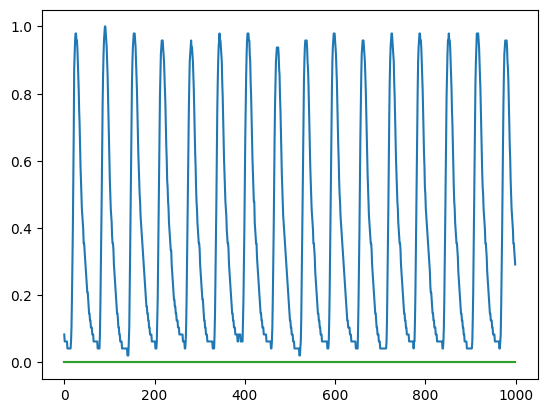

torch.Size([1, 1, 4, 1024])
0.013007156


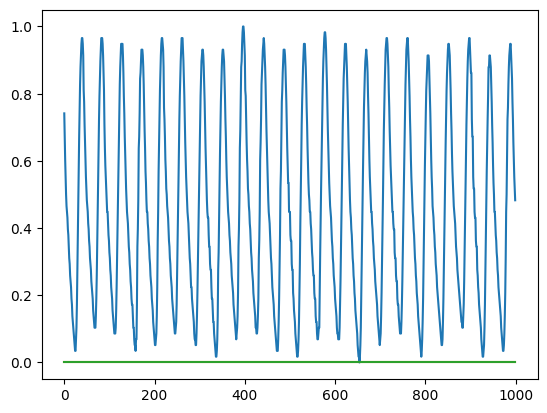

torch.Size([1, 1, 4, 1024])
0.013018455


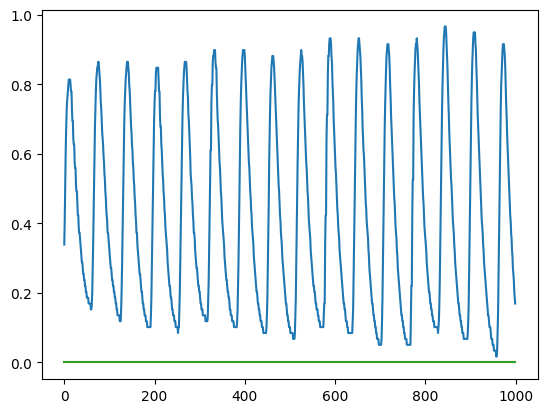

torch.Size([1, 1, 4, 1024])
0.012973558


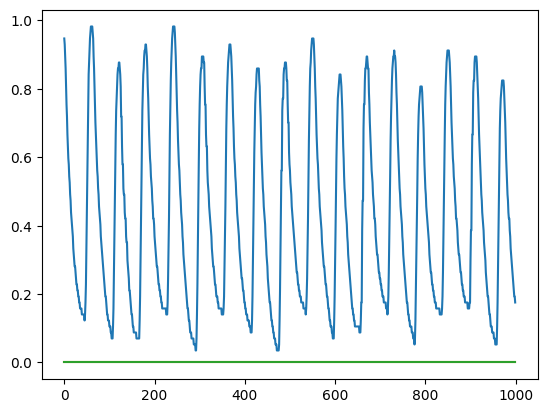

torch.Size([1, 1, 4, 1024])
0.013050052


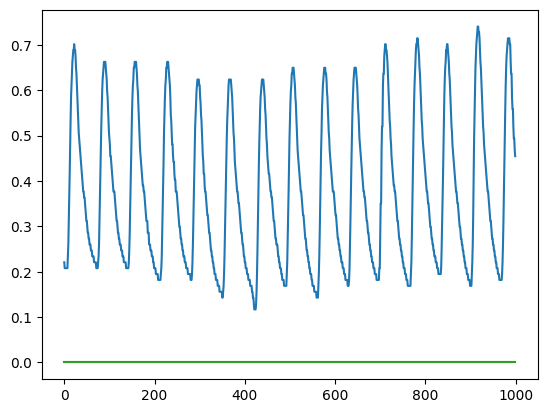

torch.Size([1, 1, 4, 1024])
0.012967891


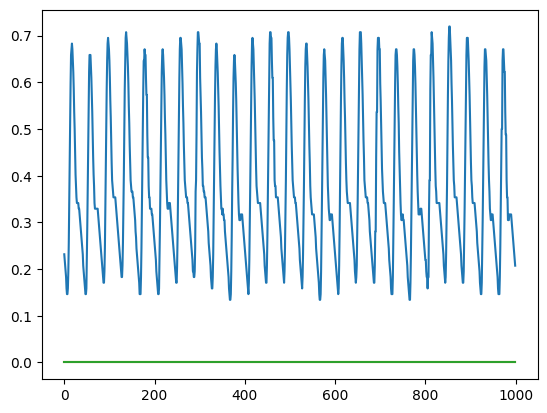

torch.Size([1, 1, 4, 1024])
0.052652106


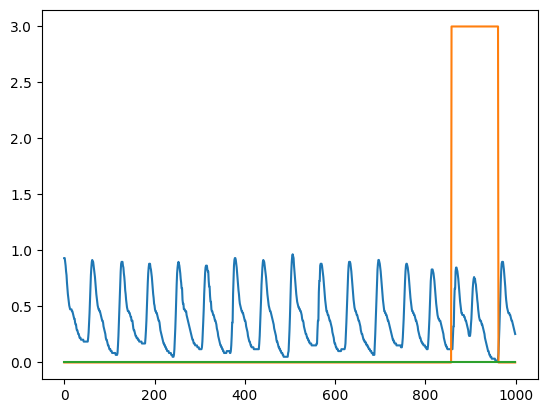

torch.Size([1, 1, 4, 1024])
0.013015306


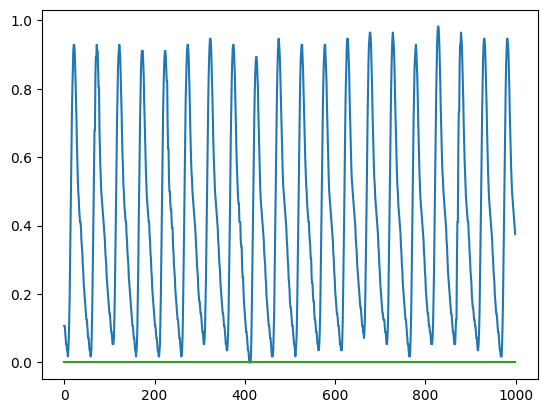

torch.Size([1, 1, 4, 1024])
0.012974803


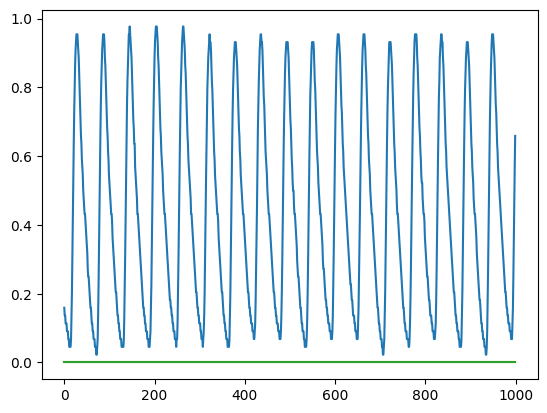

torch.Size([1, 1, 4, 1024])
0.013008651


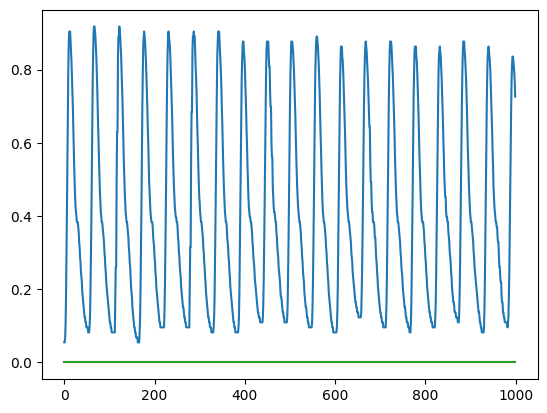

torch.Size([1, 1, 4, 1024])
0.35782933


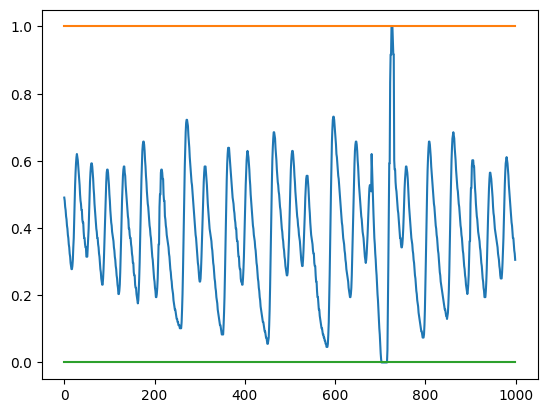

torch.Size([1, 1, 4, 1024])
0.05720643


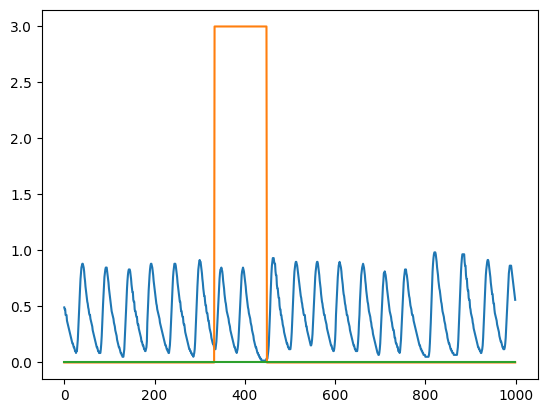

torch.Size([1, 1, 4, 1024])
0.012959731


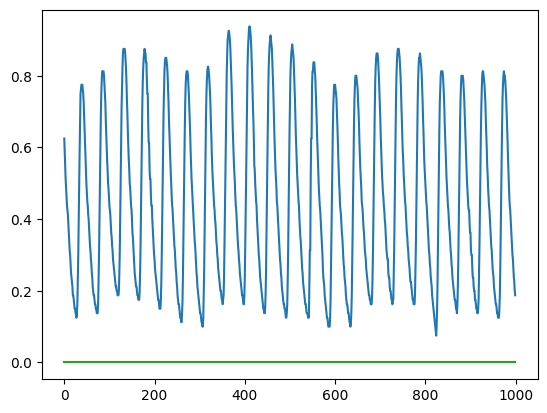

torch.Size([1, 1, 4, 1024])
0.012979461


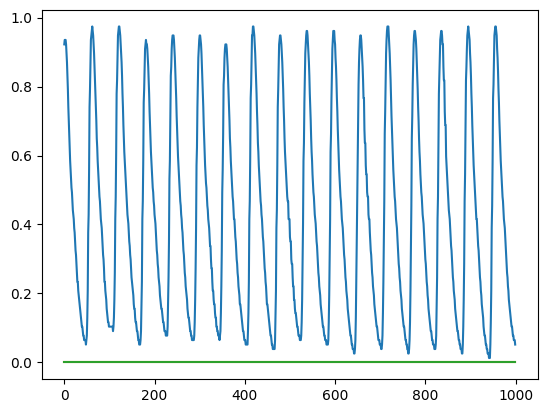

In [ ]:
shower = performance()
shower.test(model,device,test_data,per_fnc = "series")
criterion = nn.MSELoss()
for i in range(100):
    output = torch.stack([test_data[i][1]]).to(device)
    print(output.shape)
    input = torch.stack([test_data[i][0]]).to(device)
    print(input.shape)
    y_hat = model.forward(input)
    loss = criterion(y_hat,output)
    # if loss.cpu().detach().numpy()<0.3:
    print(loss.cpu().detach().numpy())
    sig = input.cpu().detach().numpy().flatten()[0:1000]
    y = output.cpu().detach().numpy()
    ly = np.argmax(y,axis=-2)
    y_hat = y_hat.cpu().detach().numpy()
    ly_hat = np.argmax(y_hat,axis=-2)
    plt.plot(sig)
    plt.plot(ly.flatten()[0:1000])
    plt.plot(ly_hat.flatten()[0:1000])


    # Show plot
    plt.show()